In [18]:
#have to install pandas_ta fist
!pip install pandas_ta

#import required libraries
#######################################################################################
#THESE LIBRARIES ARE FOR INITIAL DATA PREPARATION
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from datetime import datetime, timedelta
#FOR SCALING THE DATA
from sklearn.preprocessing import MinMaxScaler
import joblib
#FOR TRAINING THE LSTM MODEL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#set random seed for reproducibility
np.random.seed(42)
########################################################################################

######------THIS FUNCTION IS FOR GETTING 10 YEARS OF STOCK DATA----------#############
def get_ticker_data(TICKER, START_DATE = '2014-08-01', END_DATE = '2024-08-01'):

  #Download stock data
  try:
    data = yf.download(TICKER, start=START_DATE, end=END_DATE)

    #check if data is empty
    if data.empty:
      raise ValueError(f"No data found for {TICKER} from {START_DATE} to {END_DATE}")

    #display first ten rows of the data
    print(data.tail(10))

    #display basic stats:
    print("\nBasic Statistics:")
    print(data.describe())
    print("Dataset length:", len(data))

    #plot closing prices
    plt.figure(figsize=(12,6))
    plt.plot(data.index, data['Close'])
    plt.title(f'{TICKER} Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.show()

    return data

  except Exception as e:
    print(f"Error: {e}")


#############--------------ADDING INDICATOR SET-----------------###############
def add_indicators(data, indicator_set='default'):
  """
  Add technical indicators to the dataset.

  Args:
  data (pd.DataFrame): Input dataframe with OHLCV data
  indicator_set(str): 'default' or 'alternative'

  Returns:
  pd.DataFrame: Dataframe with added indicators
  """

  if indicator_set == 'default':
    #default indicator set
    data['RSI'] = ta.rsi(data.Close, length = 15)
    data['EMAF'] = ta.ema(data.Close, length = 20)
    data['EMAM'] = ta.ema(data.Close, length = 100)
    data['EMAS'] = ta.ema(data.Close, length = 150)


  elif indicator_set == 'alternative':
    #alternate indicator set
    bb = ta.bbands(data.Close, length = 20)
    data = pd.concat([data, bb], axis = 1)
    data['EMA'] = ta.ema(data.Close, length = 50)
    data['VWAP'] = ta.vwap(data.High, data.Low, data.Close, data.Volume)

  else:
    raise ValueError("Invalid indicator set. Use 'default' or 'alternative'.")

  return data

###########-------------CREATE TARGET COLUMN-------------------################
def prepare_target(data):
  """
  Prepare target variables for the LSTM model

  Args:
  data (pd.DataFrame): Input dataframe with OHLCV data

  Returns:
  pd.DataFrame: Dataframe with target variables
  """
  # Next day's price movement
  data['Target'] = data['Adj Close'] - data.Open
  data['Target'] = data['Target'].shift(-1)

  #Binary classification target
  data['TargetClass'] = (data['Target'] > 0).astype(int)

  #next day's closing price
  data['TargetNextClose'] = data['Adj Close'].shift(-1)

  return data

###########-------DROP UNNECESSARY COLUMNS, RESET INDEX--------------###########
def clean_data(data, columns_to_drop = ['Volume', 'Close', 'Date']):
  """
  Clean the dataset by dropping NaN values and specified columns

  Args:
  data (pd.DataFrame): Input dataframe
  columns_to_drop (list): List of columns to drop

  Returns:
  pd.DataFrame: Cleaned dataframe
  """
  data.dropna(inplace = True)
  print('CLEANING dropna: dataset length: ', len(data))

  data.reset_index(inplace = True)
  print('CLEANING rst idx: dataset length: ', len(data))

  data.drop(columns_to_drop, axis = 1, inplace = True)
  print('CLEANING drop col: dataset length: ', len(data))


  return data


#############----------SCALE DATA TO RANGE OF 0 TO 1-----------------################
def scale_data(data, feature_range = (0,1), save_scaler = True, scaler_path = 'scaler.pkl'):
  """
  Prepare the dataset by handling non-numeric columns first

  Scale the dataset using MinMaxScaler

  Args:
  data (pd.DataFrame or np.array): Input data to be scaled
  feature_range (tuple): Range to scale the data to (default: (0,1))
  save_scaler (bool): Whether to save the scaler object (default: True)
  scaler_path (str): Path to save the scaler object (default: 'scaler.pkl)

  Returns:
  np.array: Scaled Dataset
  MinMaxScaler: Fitted Scaler Object
  """

  numeric_columns = data.select_dtypes(include = [np.number]).columns
  non_numeric_columns = data.select_dtypes(exclude = [np.number]).columns

  if len(non_numeric_columns) > 0:
    print(f"Non-numeric columns found: {non_numeric_columns}")
    print("These columns will be dropped for scaling.")

  #select only numeric columns for scaling
  data_numeric = data[numeric_columns]

  #initialize MinMaxScaler
  scaler = MinMaxScaler(feature_range = feature_range)

  """
  #check if input is a dataframe, if so, convert to np array
  if isinstance(data, pd.DataFrame):
    data_array = data.values
  else:
    data_array = data
  """

  #fit and transform the data
  data_scaled = scaler.fit_transform(data)

  #save the scaler for later use (like inverse scaling)
  if save_scaler:
    joblib.dump(scaler, scaler_path)
    print(f"Scaler saved to {scaler_path}")

  return data_scaled, scaler


##########----------------PREPARE LSTM DATA------------------#####################
def prepare_lstm_data(data_set_scaled, backcandles = 30, target_column = -1, feature_columns = None):

  """
  Prepare data for LSTM model by creating sequences of historical data.

  Args:
  data_set_scaled (np.array): Scaled input data
  backcandles (int): Number of historical time steps to use for each sample
  target_column (int): Index of the target column (-1 for last column)
  feature_columns (list): Number of columns to use as features (N)

  Returns:
  tuple: X (input sequences), y (target values)
  """

  X = []
  print(data_set_scaled.shape[0])
  for j in feature_columns:
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
      X[j].append(data_set_scaled[i-backcandles:i, j])

  #Move axis from 0 to position 2
  X = np.moveaxis(X, [0], [2])
  #Extract target values
  y = data_set_scaled[backcandles:, target_column]

  return np.array(X), np.array(y).reshape(-1,1)



##############------------TRAIN LSTM----------------------######################
def create_and_train_lstm(X_train, y_train, backcandles = 30, features = 9, lstm_units = 150, batch_size = 15, epochs = 30, validation_split = 0.1, patience = 15):
  """
  Creates and trains lstm model

  Args:
  X_train(np.ndarray): Training input data with shape (samples, backcandles, features)
  y_train(np.ndarray): training target data
  backcandles(int): Number of time steps to look back (default = 30)
  features(int): Number of input features (default = 9)
  lstm_units(int): Number of units in LSTM layer (default = 150)
  batch_size(int): Batch size for training (default = 15)
  epochs(int): Number of epochs for training (default = 30)
  validation_split(float): fraction of training data to use for validation (default = 0.1)

  Returns:
  keras.Model: trained LSTM keras model

  """
  np.random.seed(42)
  tf.random.set_seed(42)

  lstm_input = layers.Input(shape=(backcandles, features), name='lstm_input')
  inputs = layers.LSTM(lstm_units, name='first_layer')(lstm_input)
  inputs = layers.Dense(1, name='dense_layer')(inputs)
  #inputs = layers.Dropout(0.005)(inputs) #Dropout for regulation
  output = layers.Activation('linear', name='output')(inputs)
  model = models.Model(inputs=lstm_input, outputs=output)
  adam = optimizers.Adam(learning_rate = 0.001)
  model.compile(optimizer=adam, loss='mse')

  early_stopping = EarlyStopping(monitor = 'val_loss', patience = patience, restore_best_weights = True)
  model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only = True, monitor = 'val_loss')

  history = model.fit(
      x=X_train,
      y=y_train,
      batch_size=batch_size,
      epochs=epochs,
      shuffle=True,
      validation_split = validation_split,
      callbacks = [early_stopping, model_checkpoint])

  model.summary()

  return model, history

#PREPARE DATA

In [21]:
def prepare_data(TICKER = 'SPY', START_DATE = '2014-08-01', END_DATE = '2024-08-01',
                 indicator_set = 'default', verbose = True):
  #Get ticker data:
  data = get_ticker_data(TICKER)

  if verbose:
    print('Dataset length before cleaning: ', len(data))

  data = add_indicators(data, indicator_set)

  data = prepare_target(data)
  data = clean_data(data)

  if verbose:
    print('Dataset length after cleaning: ', len(data))
    print(data.tail(20))
    print('--------------------------------------------------------------------')


  #Scale the data
  feature_range = (0,1) #adjustable
  save_scaler = True #adjustable
  scaler_path = 'lstm_scaler.pkl' #adjustable

  data_set_scaled, scaler = scale_data(data, feature_range, save_scaler, scaler_path)

  if verbose:
    print("SCALED DATA SHAPE:", data_set_scaled.shape)
    print("\nFirst few rows of scaled data:")
    print(data_set_scaled[:5])

    print("\nSCALING RANGES:")
    for i, column in enumerate(data.columns):
      print(f"{column}: {data_set_scaled[:,i].min():.4f} to {data_set_scaled[:,i].max():.4f}")

  return data_set_scaled


#TRAIN LSTM: BASICALLY THE MAIN FUNCTION

[*********************100%***********************]  1 of 1 completed


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-07-18  558.510010  559.520020  550.429993  552.659973  552.659973   
2024-07-19  552.419983  554.080017  547.909973  548.989990  548.989990   
2024-07-22  553.000000  555.270020  551.020020  554.650024  554.650024   
2024-07-23  554.539978  556.739990  553.280029  553.780029  553.780029   
2024-07-24  548.859985  549.169983  540.289978  541.229980  541.229980   
2024-07-25  541.349976  547.460022  537.450012  538.409973  538.409973   
2024-07-26  542.280029  547.190002  541.489990  544.440002  544.440002   
2024-07-29  546.020020  547.049988  542.719971  544.760010  544.760010   
2024-07-30  546.260010  547.340027  538.520020  542.000000  542.000000   
2024-07-31  548.979980  553.500000  547.580017  550.809998  550.809998   

              Volume  
Date                  
2024-07-18  56270400  
2024-07-19  65509100  
2024-07-22  4334670

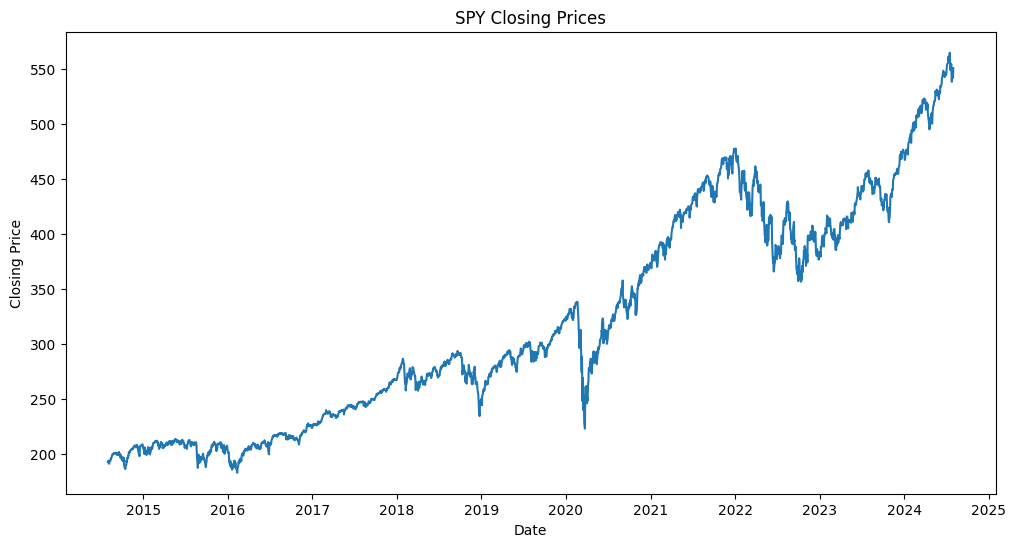

Dataset length before cleaning:  2516
CLEANING dropna: dataset length:  2366
CLEANING rst idx: dataset length:  2366
CLEANING drop col: dataset length:  2366
Dataset length after cleaning:  2366
            Open        High         Low   Adj Close        RSI        EMAF  \
2346  543.700012  549.010010  543.650024  549.010010  68.834799  541.366375   
2347  548.690002  551.830017  548.650024  551.460022  71.242570  542.327674   
2348  551.770020  555.049988  551.119995  554.640015  74.032518  543.500278   
2349  555.440002  556.250000  554.190002  555.280029  74.564639  544.622159   
2350  556.260010  557.179993  555.520020  555.820007  75.027230  545.688621   
2351  557.070007  561.669983  556.770020  561.320007  79.162904  547.177324   
2352  561.440002  562.330017  555.830017  556.479980  68.471436  548.063292   
2353  557.630005  563.669983  557.150024  559.989990  71.465804  549.199168   
2354  562.030029  564.840027  559.630005  561.530029  72.685309  550.373535   
2355  562.86999

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)              │ (None, 30, 9)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (LSTM)                   │ (None, 150)                 │          96,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 1)                   │             151 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Activation)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 288,455 (1.10 MB)

 Trainable params: 96,151 (375.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 192,304 (751.19 KB)

In [26]:
#DEFINE VARIABLES
TICKER = 'SPY'
START_DATE = '2014-08-01'
END_DATE = datetime.now().strftime('%Y-%m-%d')
#scaler usage
backcandles = 30 #also used for training function
target_column = -1 #last column
feature_columns = [0,1,2,3,4,5,6,7,8]
#Training Usage
features = len(feature_columns)
lstm_units = 150
batch_size = 15
epochs = 300
validation_split = 0.1
patience = 20
#Prepare data
data_set_scaled = prepare_data(TICKER, START_DATE, END_DATE)
X, y = prepare_lstm_data(data_set_scaled, backcandles, target_column, feature_columns)

print("Input shape (X):", X.shape)
print("Target shape (y):", y.shape)

print("\nSample input sequence:")
print(X[0])
print("\nCorresponding target value:")
print(y[0])
print('\n-----------------------------------------------------------------------------\n')
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

print('\n-----------------------------------------------------------------------------\n')
#TRAIN THE MODEL
model, history = create_and_train_lstm(X_train, y_train, backcandles, features, lstm_units, batch_size, epochs, validation_split, patience)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
test size: 468


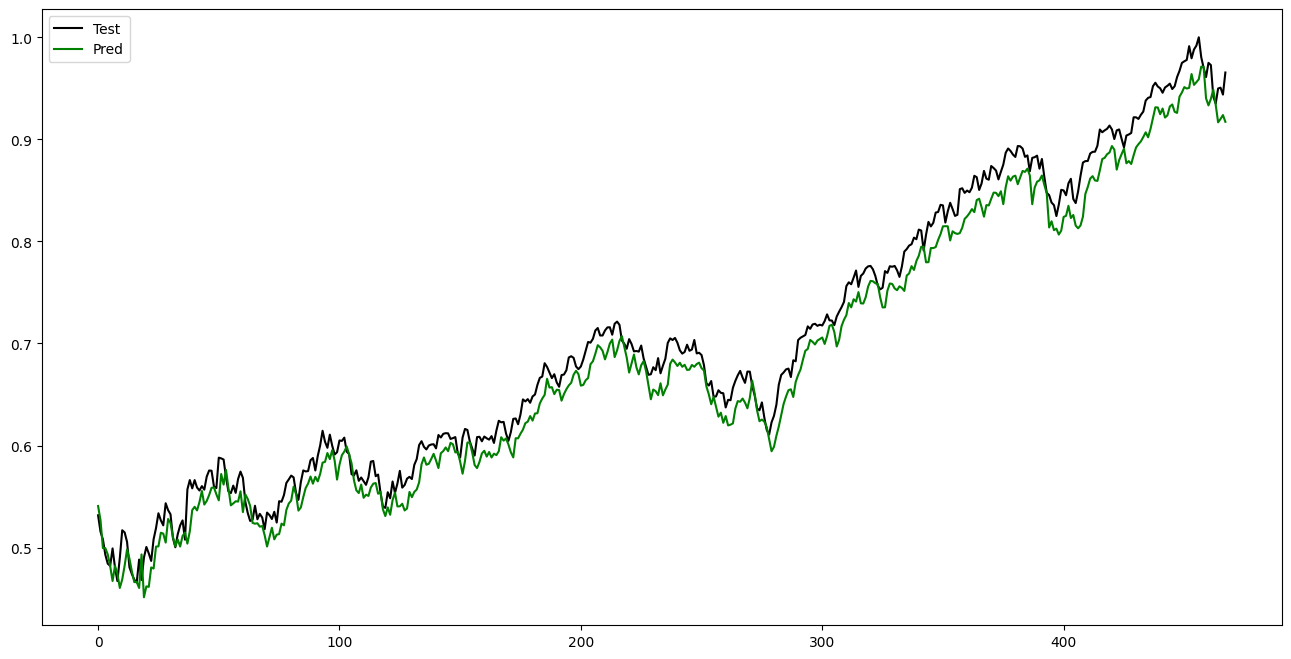

In [27]:
y_predict = model.predict(X_test)
print('test size:', len(y_predict))
#for i in range(len(y_predict)):
  #  print(y_predict[i], y_test[i])

plt.figure(figsize = (16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_predict, color = 'green', label = 'Pred')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed

original dataset length: 2545
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-09-05  550.890015  553.799988  547.099976  549.609985  549.609985   
2024-09-06  549.940002  551.599976  539.440002  540.359985  540.359985   
2024-09-09  544.650024  547.710022  542.679993  546.409973  546.409973   
2024-09-10  548.359985  549.150024  543.380005  548.789978  548.789978   
2024-09-11  548.700012  555.359985  539.960022  554.419983  554.419983   

              Volume  
Date                  
2024-09-05  44264300  
2024-09-06  68493800  
2024-09-09  40445800  
2024-09-10  36394600  
2024-09-11  75248600  
Cleaned dataset length: 2545
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-08-28  561.210022  561.650024  555.039978  558.299988  558.299988   
2024-08-29  560.309998  563.679993  557

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
PREDICTING NEXT DAY:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


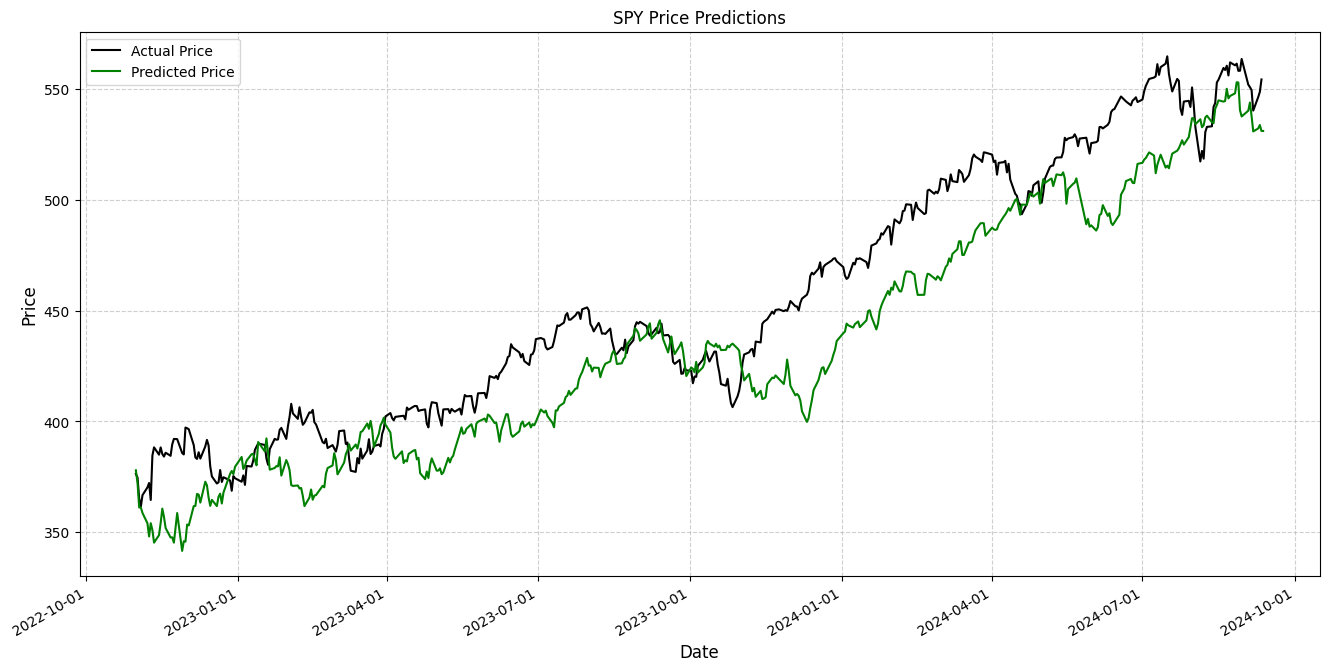

FIRST FEW PREDICTIONS
        Date  Predicted Price  Actual Price
0 2022-10-31       377.940332    376.302094
1 2022-11-01       372.300339    374.655457
2 2022-11-02       361.138180    365.253021
3 2022-11-03       361.141674    361.492035
4 2022-11-04       358.655959    366.695038

LAST FEW PREDICTIONS WITH NEXT DAY
          Date  Predicted Price  Actual Price
464 2024-09-06       530.938674    540.359985
465 2024-09-09       532.286089    546.409973
466 2024-09-10       533.845529    548.789978
467 2024-09-11       531.151015    554.419983
0   2024-09-12       531.150991           NaN


In [28]:
#---------------------------------------------------------------------------
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#---------------------------------------------------------------------------

def inverse_transform_predictions(scaler, scaled_predictions, feature_index):
  """
  Inverses transform the scaled predictions back to original scale

  Args:
  scaler (MinMaxScaler): The fitted scaler object
  scaled_predictions (np.array): The scaled predictions
  feature_index (int): The index of the feature to inverse transform

  Returns:
  np.array: The inverse transformed predictions

  """

  #Create a dummy array with the same shape as the training data
  dummy_array = np.zeros((len(scaled_predictions), scaler.n_features_in_))

  #put the predictions into the correct column
  dummy_array[:, feature_index] = scaled_predictions.flatten()

  #inverse transform
  return scaler.inverse_transform(dummy_array)[:, feature_index]

# Function to get the next trading day
def next_trading_day(date, holidays):
    next_day = date + pd.Timedelta(days=1)
    while next_day.weekday() >= 5 or next_day in holidays:
        next_day += pd.Timedelta(days=1)
    return next_day



# Update the next_day variable in the get_price_predictions function
def get_price_predictions(model, X_test, scaler, original_data, backcandles, target_column_index):
    """
    Get price predictions with corresponding dates.

    Args:
    model (keras.Model): The trained LSTM model
    X_test (np.array): The test input data
    scaler (MinMaxScaler): The fitted scaler object
    original_data (pd.DataFrame): The original dataframe with dates
    backcandles (int): The number of historical candles used for each prediction
    target_column_index (int): The index of the target column in the original dataset

    Returns:
    pd.DataFrame: A dataframe with dates and predicted prices
    """
    # Make predictions
    print('PREDICTING TEST SET:')
    y_predict_scaled = model.predict(X_test)

    # Inverse transform predictions
    y_predict = inverse_transform_predictions(scaler, y_predict_scaled, target_column_index)

    # Get the dates for the test set
    test_dates = original_data.index[-len(X_test):]

    # Create a dataframe with dates and predictions
    predictions_df = pd.DataFrame({
        'Date': test_dates,
        'Predicted Price': y_predict.flatten(),
        'Actual Price': original_data['Adj Close'].values[-len(X_test):]
    })
    print('PREDICTING NEXT DAY:')
    # Predict the next day
    last_sequence = X_test[-1:].reshape(1,backcandles, -1)
    next_day_scaled = model.predict(last_sequence)
    next_day_price = inverse_transform_predictions(scaler, next_day_scaled, target_column_index)

    #get next trading day
    # Create a holiday calendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=data.index.min(), end=data.index.max())
    # Adjust the next day prediction to handle weekends and holidays
    last_date = data.index[-1]
    next_trading_date = next_trading_day(last_date, holidays)

    # Add the next day prediction
    next_day_prediction = pd.DataFrame({
        'Date': [next_trading_date],
        'Predicted Price': next_day_price.flatten(),
        'Actual Price': [np.nan] #placeholder for unknown actual price
    })

    # Concatenate the predictions with the next day prediction
    predictions_df = pd.concat([predictions_df, next_day_prediction])

    return predictions_df



#----------------------------------------------------------------------------------
# Load the original data again
data = yf.download(TICKER, start=START_DATE, end=END_DATE)
print("original dataset length:", len(data))
print(data.tail(5))

#remove rows with Nan values but keep the last row
data_cleaned = data.dropna().iloc[:-1]
last_row = data.iloc[-1:]
data_cleaned = pd.concat([data_cleaned, last_row])

print("Cleaned dataset length:", len(data_cleaned))
print(data_cleaned.tail(10))

# Load the saved scaler
scaler = joblib.load('lstm_scaler.pkl')

# Get price predictions
predictions_df = get_price_predictions(model, X_test, scaler, data, backcandles, target_column_index=-1)

plt.figure(figsize = (16,8))

plt.plot(predictions_df['Date'],
         predictions_df['Actual Price'],
         color = 'black',
         label = 'Actual Price')
plt.plot(predictions_df['Date'],
         predictions_df['Predicted Price'],
         color = 'green',
         label = 'Predicted Price')
plt.title(f'{TICKER} Price Predictions')
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Price', fontsize = 12)
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
# Print the first few predictions
print('FIRST FEW PREDICTIONS')
print(predictions_df.head())
print('\nLAST FEW PREDICTIONS WITH NEXT DAY')
# Print the last few predictions
print(predictions_df.tail())

#Here I am going to add some cells for evaluating the training history and overall performance.

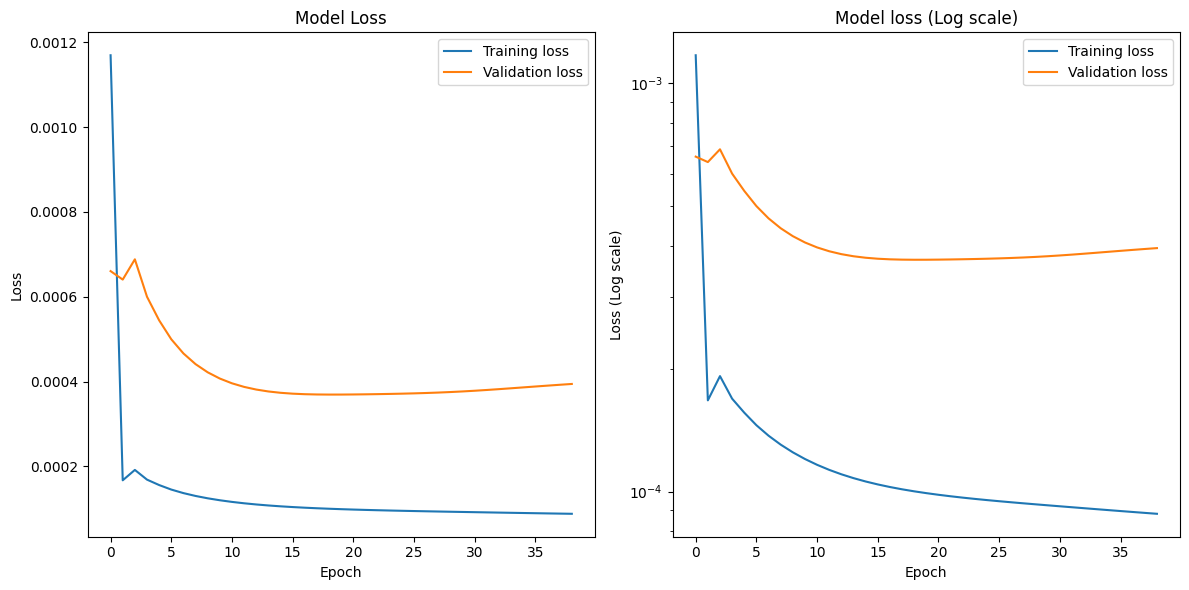

In [9]:
def plot_training_history(history):
  plt.figure(figsize = (12,6))
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'], label = 'Training loss')
  plt.plot(history.history['val_loss'], label = 'Validation loss')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'], label = 'Training loss')
  plt.plot(history.history['val_loss'], label = 'Validation loss')
  plt.title('Model loss (Log scale)')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (Log scale)')
  plt.yscale('log')
  plt.legend()

  plt.tight_layout()
  plt.show()

plot_training_history(history)

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(y_true, y_pred, set_name=""):
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  print(f"{set_name} Metrics:")
  print(f"MSE: {mse:.4f}")
  print(f"RMSE: {rmse:.4f}")
  print(f"MAE: {mae:.4f}")
  print(f"R^2 score: {r2:.4f}\n")

#metrics for training set
y_train_pred = model.predict(X_train)
calculate_metrics(y_train, y_train_pred, "Training")
#metrics for test set:
y_test_pred = model.predict(X_test)
calculate_metrics(y_test, y_test_pred, "Test")


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Training Metrics:
MSE: 0.0001
RMSE: 0.0105
MAE: 0.0070
R^2 score: 0.9974

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test Metrics:
MSE: 0.0002
RMSE: 0.0138
MAE: 0.0108
R^2 score: 0.9905



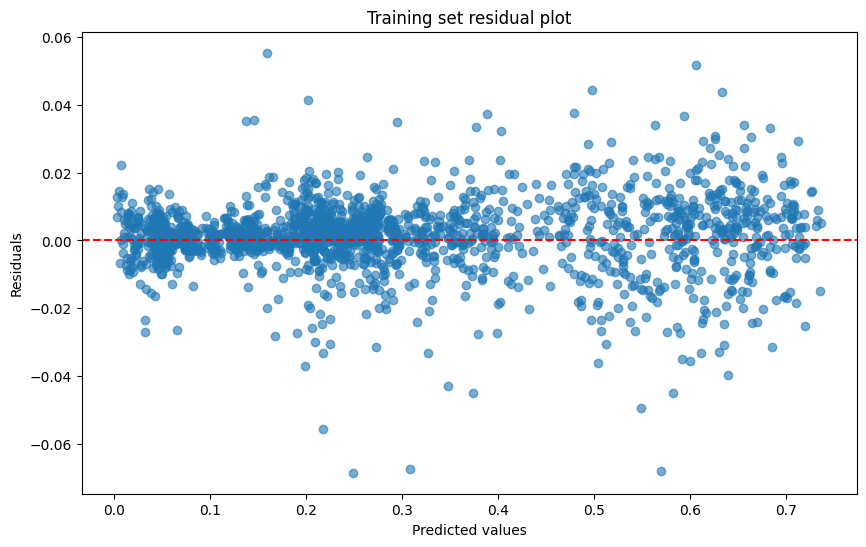

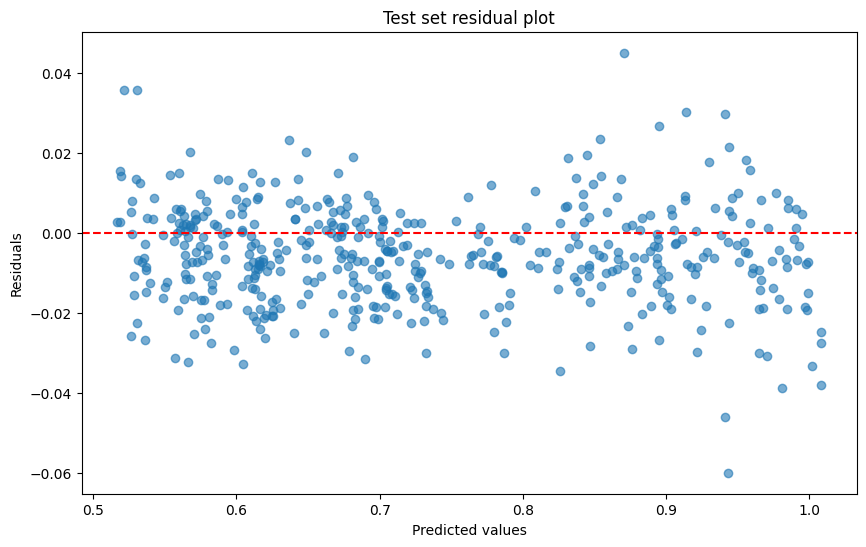

In [11]:
#function for residual plot:
def plot_residuals(y_true, y_pred, title = "Residual Plot"):
  residuals = y_true - y_pred
  plt.figure(figsize = (10, 6))
  plt.scatter(y_pred, residuals, alpha = 0.6)
  plt.title(title)
  plt.xlabel('Predicted values')
  plt.ylabel('Residuals')
  plt.axhline(y = 0, color = 'r', linestyle = '--')
  plt.show()

plot_residuals(y_train, y_train_pred, "Training set residual plot")
plot_residuals(y_test, y_test_pred, 'Test set residual plot')

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


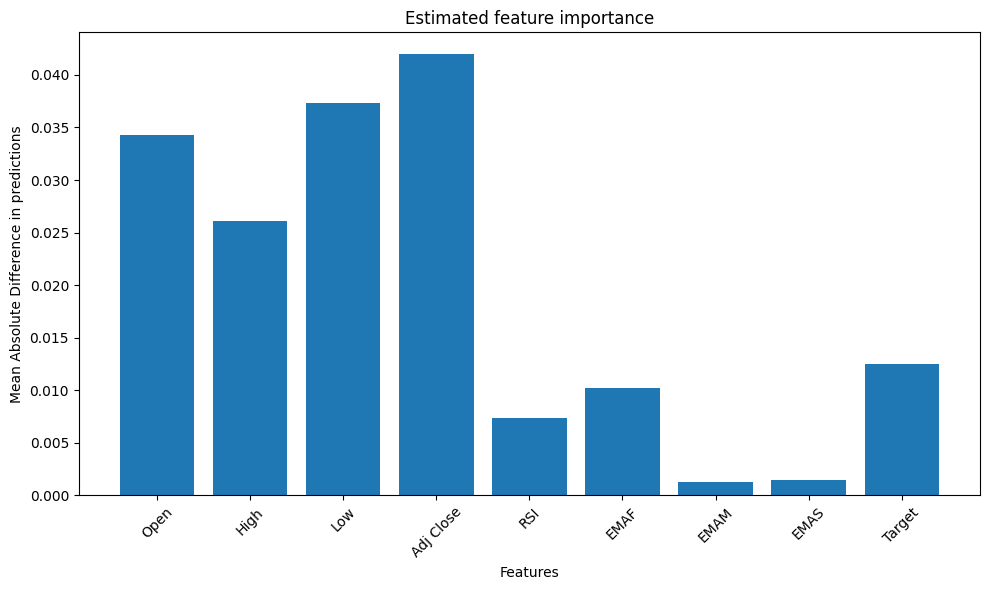

In [12]:
#estimating feature importance:
def estimate_feature_importance(model, X, feature_names):
  baseline_pred = model.predict(X)
  importance = []

  for i in range(X.shape[2]):
    X_permuted = X.copy()
    X_permuted[:,:,i] = np.random.permutation(X_permuted[:,:,i])
    permuted_pred = model.predict(X_permuted)
    importance.append(np.mean(np.abs(baseline_pred - permuted_pred)))

  plt.figure(figsize = (10,6))
  plt.bar(feature_names, importance)
  plt.title('Estimated feature importance')
  plt.xlabel('Features')
  plt.ylabel('Mean Absolute Difference in predictions')
  plt.xticks(rotation = 45)
  plt.tight_layout()
  plt.show()

feature_names = ['Open', 'High', 'Low', 'Adj Close', 'RSI', 'EMAF', 'EMAM', 'EMAS', 'Target']
estimate_feature_importance(model, X_test, feature_names)

#This is a rolling window approach that will evaluate the performance across different training sizes. It should give a better idea of how it will perform when predicting out of sample data.

Epoch 1/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 2/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 2.7839e-04 - val_loss: 2.7166e-04
Epoch 3/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 8.9820e-05 - val_loss: 3.0205e-04
Epoch 4/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 7.6619e-05 - val_loss: 2.0484e-04
Epoch 5/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 6.3696e-05 - val_loss: 1.6886e-04
Epoch 6/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 5.7366e-05 - val_loss: 1.3725e-04
Epoch 7/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 5.2939e-05 - val_loss: 9.3121e-05
Epoch 8/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 4.8197e-05 - val_loss: 5.7390e-05
Epoch 9/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 4.4297e-05 - val_loss: 4.5022e-05
Epoch 10/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 4.2113e-05 - val_loss: 4.2171e-05
Epoch 11/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 4.1226

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)              │ (None, 30, 9)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (LSTM)                   │ (None, 150)                 │          96,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 1)                   │             151 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Activation)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 288,455 (1.10 MB)

 Trainable params: 96,151 (375.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 192,304 (751.19 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Epoch 1/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0030 - val_loss: 1.8574e-04
Epoch 2/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 8.0266e-05 - val_loss: 2.1793e-04
Epoch 3/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 5.7470e-05 - val_loss: 2.4620e-04
Epoch 4/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 5.5008e-05 - val_loss: 1.2267e-04
Epoch 5/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 4.2546e-05 - val_loss: 1.0583e-04
Epoch 6/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 3.9956e-05 - val_loss: 9.5142e-05
Epoch 7/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 3.8159e-05 - val_loss: 8.5678e-05
Epoch 8/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 3.7107e-05 - val_loss: 8.4607e-05
Epoch 9/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 3.7212e-05 - val_loss: 8.7238e-05
Epoch 10/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 3.7478e-05 - val_loss: 9.0701e-05
Epoch 11/300
48/48 ━━━━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)              │ (None, 30, 9)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (LSTM)                   │ (None, 150)                 │          96,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 1)                   │             151 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Activation)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 288,455 (1.10 MB)

 Trainable params: 96,151 (375.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 192,304 (751.19 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 1/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0072 - val_loss: 2.0157e-04
Epoch 2/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 1.1789e-04 - val_loss: 8.4869e-05
Epoch 3/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 9.4360e-05 - val_loss: 6.2294e-05
Epoch 4/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 8.5635e-05 - val_loss: 6.6448e-05
Epoch 5/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 7.4513e-05 - val_loss: 7.5905e-05
Epoch 6/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 6.9096e-05 - val_loss: 7.7800e-05
Epoch 7/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.3907e-05 - val_loss: 7.9273e-05
Epoch 8/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 6.0712e-05 - val_loss: 8.0537e-05
Epoch 9/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 5.8685e-05 - val_loss: 7.3933e-05
Epoch 10/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.6316e-05 - val_loss: 6.3275e-05
Epoch 11/300
71/71 ━━━━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)              │ (None, 30, 9)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (LSTM)                   │ (None, 150)                 │          96,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 1)                   │             151 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Activation)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 288,455 (1.10 MB)

 Trainable params: 96,151 (375.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 192,304 (751.19 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 1/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0066 - val_loss: 3.2454e-04
Epoch 2/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.6840e-04 - val_loss: 4.0192e-04
Epoch 3/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 1.5095e-04 - val_loss: 3.5637e-04
Epoch 4/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 1.3389e-04 - val_loss: 3.7462e-04
Epoch 5/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 1.2461e-04 - val_loss: 5.0148e-04
Epoch 6/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.1990e-04 - val_loss: 5.6577e-04
Epoch 7/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 1.1396e-04 - val_loss: 5.5609e-04
Epoch 8/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.0740e-04 - val_loss: 5.0711e-04
Epoch 9/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.0107e-04 - val_loss: 4.5027e-04
Epoch 10/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 9.5541e-05 - val_loss: 4.0738e-04
Epoch 11/300
95/95 ━━━━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)              │ (None, 30, 9)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (LSTM)                   │ (None, 150)                 │          96,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 1)                   │             151 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Activation)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 288,455 (1.10 MB)

 Trainable params: 96,151 (375.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 192,304 (751.19 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Epoch 1/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0024 - val_loss: 6.2392e-04
Epoch 2/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 2.8853e-04 - val_loss: 4.5224e-04
Epoch 3/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 2.6268e-04 - val_loss: 4.6361e-04
Epoch 4/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 2.4538e-04 - val_loss: 4.3010e-04
Epoch 5/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 2.2208e-04 - val_loss: 4.0323e-04
Epoch 6/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 2.0577e-04 - val_loss: 3.8142e-04
Epoch 7/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 1.9329e-04 - val_loss: 3.6535e-04
Epoch 8/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 1.8367e-04 - val_loss: 3.5395e-04
Epoch 9/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 1.7606e-04 - val_loss: 3.4605e-04
Epoch 10/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 1.6993e-04 - val_loss: 3.4058e-04
Epo

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)              │ (None, 30, 9)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (LSTM)                   │ (None, 150)                 │          96,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 1)                   │             151 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Activation)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 288,455 (1.10 MB)

 Trainable params: 96,151 (375.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 192,304 (751.19 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


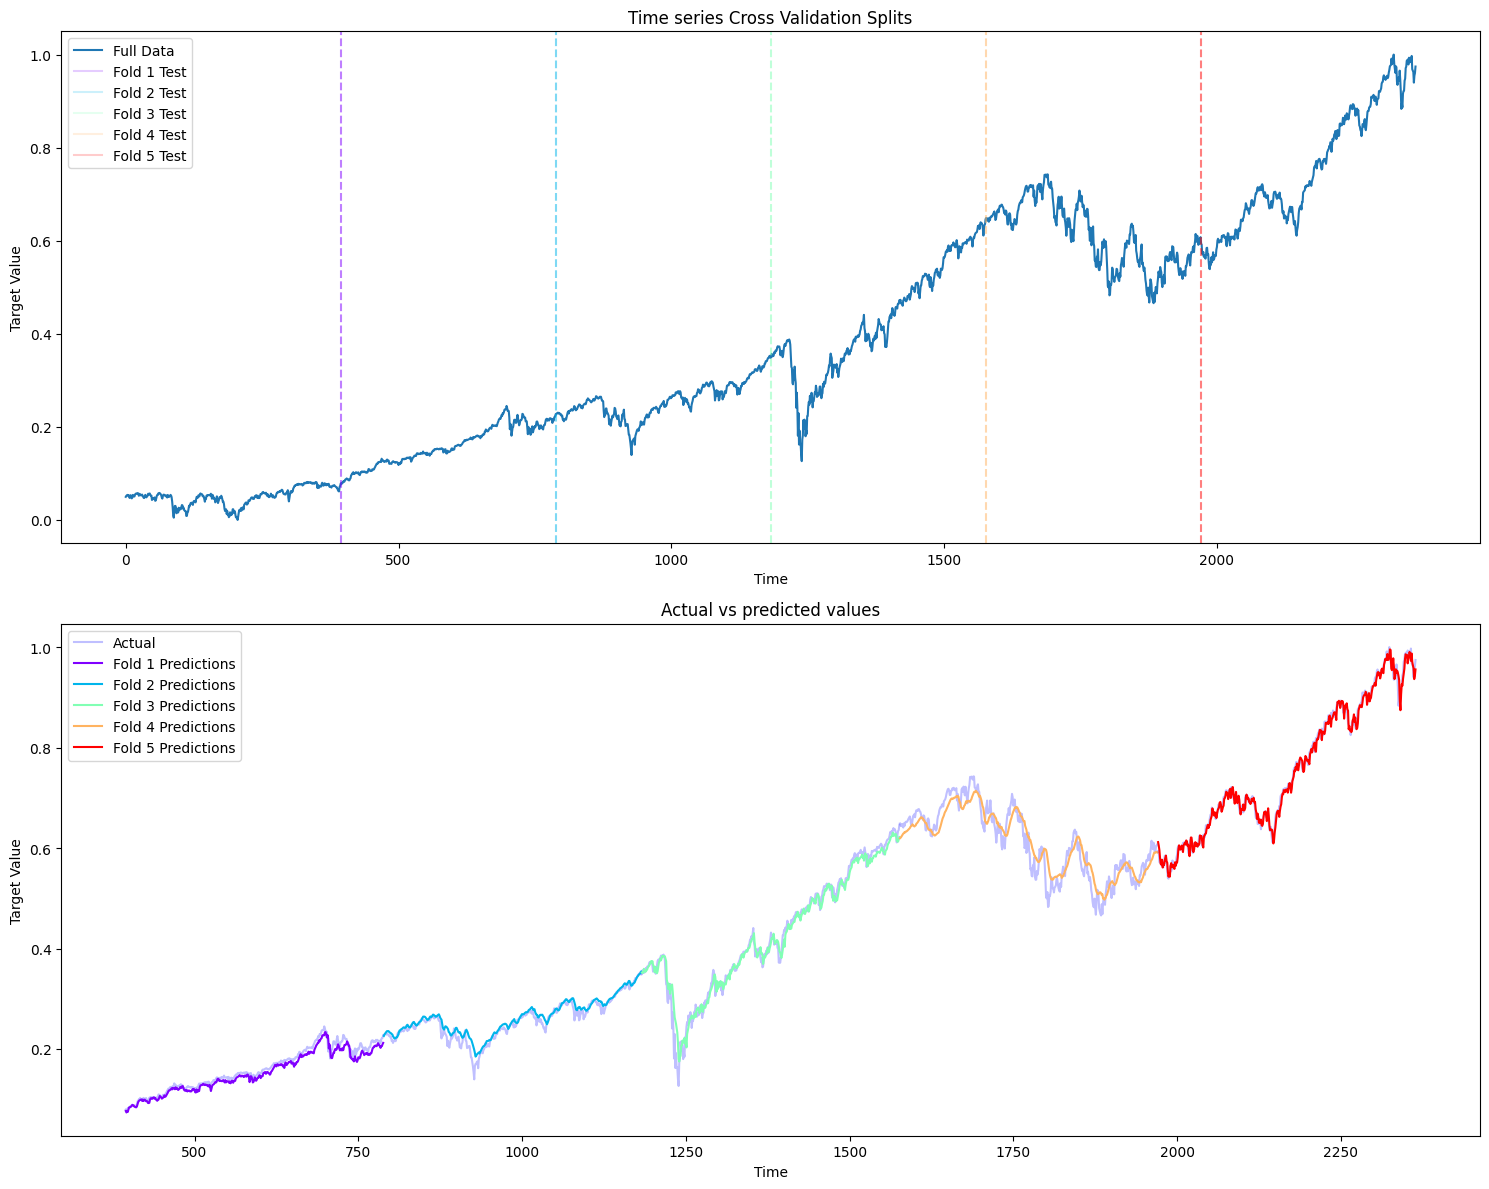

MSE - Mean: 0.0003, Std: 0.0002
RMSE - Mean: 0.0152, Std: 0.0059
MAE - Mean: 0.0115, Std: 0.0050
R2 - Mean: 0.9379, Std: 0.0481


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def time_series_cv_lstm(X, y, n_splits = 5, backcandles = 30, features = 9, lstm_units = 150, batch_size = 15, epochs = 30):
  tscv = TimeSeriesSplit(n_splits = n_splits)

  cv_scores = {
      'mse': [],
      'rmse': [],
      'mae': [],
      'r2': []
  }

  #prepare plots
  fig, (ax1,ax2) = plt.subplots(2,1,figsize = (15,12))
  colors =  plt.cm.rainbow(np.linspace(0,1, n_splits))

  #plot data and splits
  ax1.plot(range(len(y)), y, label='Full Data')
  ax1.set_title('Time series Cross Validation Splits')
  ax1.set_xlabel('Time')
  ax1.set_ylabel('Target Value')

  for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #plot splits
    ax1.axvline(x=train_index[-1], color = colors[fold], linestyle = '--', alpha = 0.5)
    ax1.axvline(train_index[-1], test_index[-1], alpha=0.2, color = colors[fold], label = f'Fold {fold+1} Test')

    #reset and recreate the model for each fold
    tf.keras.backend.clear_session()
    model, history = create_and_train_lstm(X_train, y_train, backcandles, features, lstm_units, batch_size, epochs)

    #make predictions
    y_pred = model.predict(X_test)

    #Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)


    #Store scores:
    cv_scores['mse'].append(mse)
    cv_scores['rmse'].append(rmse)
    cv_scores['mae'].append(mae)
    cv_scores['r2'].append(r2)

    #plot predictions
    ax2.plot(test_index, y_test, color = 'blue', alpha = 0.25, label = 'Actual' if fold == 0 else '')
    ax2.plot(test_index, y_pred, color = colors[fold], label = f'Fold {fold+1} Predictions')

  ax1.legend(loc = 'upper left')
  ax2.set_title('Actual vs predicted values')
  ax2.set_xlabel('Time')
  ax2.set_ylabel('Target Value')
  ax2.legend()
  plt.tight_layout()
  plt.show()

  #calculate mean and std scores:
  for metric in cv_scores:
    print(f'{metric.upper()} - Mean: {np.mean(cv_scores[metric]):.4f}, Std: {np.std(cv_scores[metric]):.4f}')

  return cv_scores, fig
#define n_splits, use all other previous hyperparamters
n_splits = 5
cv_scores, fig = time_series_cv_lstm(X,y,n_splits=5, backcandles=backcandles, features=features, lstm_units=lstm_units, batch_size=batch_size, epochs=epochs)

#Below is some additional cells for trying to get an actual price prediction. I will return to these once I get a better idea of how the training and base predictions are going